# Algoritmos genéticos

Inspirados en conceptos de la evolución biológica y su base genético-molecular.

- Aquellos individuos que tienen más éxito en sobrevivir y en atraer compañeros tienen mayor probabilidad de generar un gran número de descendientes
- Los genes de los individuos mejor adaptados se propagarán en sucesivas generaciones.
- La combinación de buenas características provenientes de diferentes ancestros, puede a veces producir descendientes ***"superindividuos"*** 

### En computación 

Se trabaja con una población de individuos y cada individuo representa **una solución** a un problema. 

- A cada individuo se le asigna un puntaje relacionado con el nivel de adaptación
    - Una mayor probabilidad de reproducirse y cruzar material genético
    - El cruce produce individuos que comparten caracteristicas de sus padres.
- El cruce genera una nueva población, que contiene mejores caracteristicas que las anteriores.
- La población convergerá hacia una solución óptima. 

##### Keywords
**seleccion, cruce, mutación, reducción**, hibridación

### Tipos de problemas

Estamos tratando con problemas NP (Non-deterministic search, polinomial check), en los que una búsqueda exhaustiva es simplemente imposible.

El problema TSP (Travelling Sales Person) trata de encontrar en recorrido más corto que pase por todas las ciudades de un conjunto dado.


Refs:

- GA Tutorial [here](http://www.obitko.com/tutorials/genetic-algorithms/index.php)
- Compendium of NP Optimization Problems [here](http://www.csc.kth.se/~viggo/problemlist/)    
    

### Generando un conjunto de localizaciones de  ciudades

[[ 2 88]
 [87 84]
 [84  6]
 [99 37]
 [60 87]
 [ 8 83]
 [43 33]
 [45 66]
 [28 94]
 [ 3 56]
 [14 92]
 [88 10]
 [33 12]
 [33 85]
 [69 60]
 [67 58]
 [80 19]
 [81 30]
 [69 21]
 [78 35]]


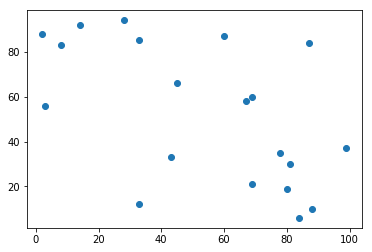

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
w_size = 100
n_cities = 20
cities = (np.random.random((n_cities,2))*w_size).astype(int)
cities = np.array([[ 2,88],[87,84],[84,6],[99,37], [60, 87], [ 8, 83], [43, 33], [45, 66], [28, 94], [ 3, 56], [14, 92], [88, 10], [33, 12], [33, 85], [69, 60], [67, 58], [80, 19], [81, 30], [69, 21], [78, 35]])

plt.scatter(cities[:,0], cities[:,1])
print cities

In [2]:
def TSP_plot_solution(cities, solution):
    plt.scatter(cities[:,0], cities[:,1])
    plt.plot(cities[solution,0].tolist()+[cities[solution[0],0]], cities[solution,1].tolist()+[cities[solution[0],1]])
    plt.scatter(cities[solution[0],0], cities[solution[0],1], marker="x", s=60, c="red", lw="5")
    plt.title("cost %.3f"%(TSP_cost(cities, solution)))
    
def TSP_cost(cities, solution):
    sol_cities = cities[solution]
    return np.sum(np.sqrt(np.sum((sol_cities - np.roll(sol_cities,-1, axis=0))**2, axis=1)))

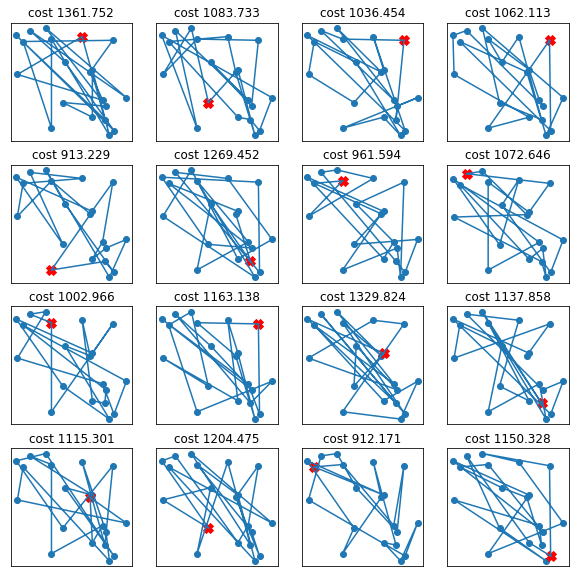

In [3]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    ax = fig.add_subplot(4,4,i+1)
    one_solution = np.random.permutation(n_cities)
    TSP_plot_solution(cities, one_solution)
    ax.set_xticks([])
    ax.set_yticks([])

## Estructura del algoritmo genético
### Términos biológicos y computacionales

- Cada **solución** se representa por un conjunto de parametros denominados **genes**. 
- El grupo de **genes** representa la solución, denominada **cromosoma**. En general se denomina un **fenotipo**
- La **función de adaptación** asigna un valor a un **cromosoma** particular que representa el nivel de adaptación
- La **fase de reproducción** selecciona los padres y sus **cromosomas** se combinan utilizando las operaciones de **cruce** y **mutación**
    - Organismos bien adaptados se pueden escoger varias veces

#### 1) Se inicia aleatoriamente una población

In [4]:
def TSP_initialize_population(n_individuals, n_cities):
    r = []
    for i in xrange(n_individuals):
        r.append(np.random.permutation(n_cities))
    return np.array(r)

#### 2) El **operador del cruce**

A partir de dos padres escogidos, los cromosomas se parten en posiciones al azar para producir dos cromosomas nuevos

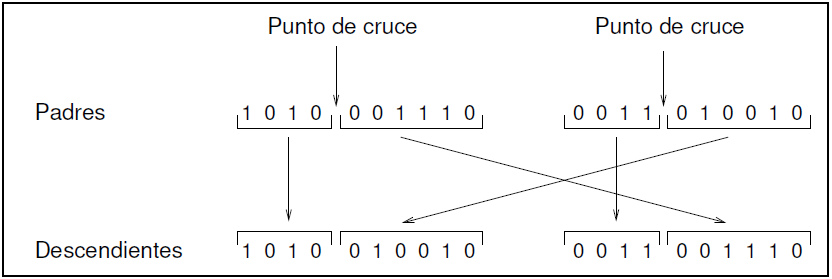

In [6]:
from IPython.display import Image
Image(filename='../imgs/ga_1.png', width=700)

In [7]:
def TSP_cross_over(solution1, solution2):
    l = len(solution1)
    cstart = np.random.randint(l)
    cend   = np.random.randint(l-cstart)+cstart+1
    
    r = np.zeros(l)
    s1part = solution1[cstart:cend]
    r[cstart:cend] = s1part
    c = 0
    for i in range(l):
        c = cend if c==cstart else c
        if not solution2[i] in s1part:
            r[c]=solution2[i]
            c += 1
            
    return r


#### 3) El **operador del mutación**
Se aplica a cada hijo, donde se altera aleatoriamente cada **gen** del **cromosoma**. Normalmente con probabilidad baja.

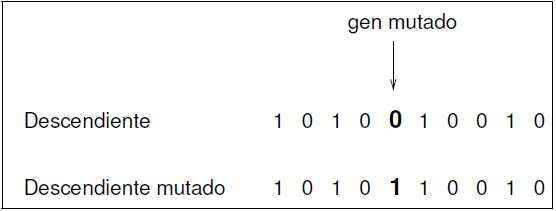

In [8]:
from IPython.display import Image
Image(filename='../imgs/ga_2.png', width=400)

In [9]:
def TSP_mutate(solution, mutation_prob):
    mutated_solution = np.copy(solution)
    for i in range(len(solution)):
        if np.random.random()<mutation_prob:
            j = i+1 if i!=len(solution)-1 else 0
            tmp = mutated_solution[i]
            mutated_solution[i] = mutated_solution[j]
            mutated_solution[j] = tmp
    return mutated_solution

In [10]:
def TSP_plot_GA_result(best, bests, means, stds):
    fig = plt.figure(figsize=(12,4))
    fig.add_subplot(121)
    plot_evolution(bests, means, stds)
    fig.add_subplot(122)
    TSP_plot_solution(cities, best)

### Algoritmo general con algoritmos genéticos

In [17]:
%%writefile ../code/ga.py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

def plot_evolution(bests, means, stds):
    plt.plot(means, label="means")
    plt.plot(bests, label="bests")
    plt.fill_between(range(len(means)), means-stds, means+stds, color="yellow", alpha=0.2)
    plt.legend()
    

def run_ga(pop_size, init_population_function, 
           mutation_function, crossover_function, cost_function, 
           crossover_prob, mutation_prob, n_iters):

    pop = init_population_function(pop_size)
    n_xover_indivs = int(pop_size * crossover_prob)

    means = []
    stds  = []
    best_costs = []
    best = None

    for i in tqdm(range(n_iters)):

        #if i%(n_iters/10)==0:
        # print i
        
        # do cross over
        offsprings = []
        permut_temp = np.random.permutation(len(pop))
        idx_xover_indivs = permut_temp[n_xover_indivs:]
        #print "permut_temp: ", permut_temp
        #print "idx_xover_indivs: ", idx_xover_indivs
        for idx in idx_xover_indivs:
            idx_counterpart = np.random.randint(len(pop))
            i1 = pop[idx]
            i2 = pop[idx_counterpart]
            offs = crossover_function(i1,i2)
            offsprings.append(offs)
        offsprings = np.array(offsprings)

        pop = np.vstack((pop, offsprings)).astype(int)

        # mutate population
        for j in xrange(len(pop)):
            pop[j] = mutation_function(pop[j], mutation_prob)

        # select best to maintain pop_size fixed
        costs = np.array([cost_function(j) for j in pop])
        top_idxs  = np.argsort(costs)[:pop_size]
        pop = pop[top_idxs]

        costs = costs[top_idxs]

        means.append(np.mean(costs))
        stds.append(np.std(costs))
        best_costs.append(np.min(costs))
        
        if best is None or np.min(costs) < cost_function(best):
             best = pop[np.argmin(costs)]

    means      = np.array(means)
    stds       = np.array(stds)
    best_costs = np.array(best_costs)
    
    
    return best, best_costs, means, stds


Overwriting ../code/ga.py


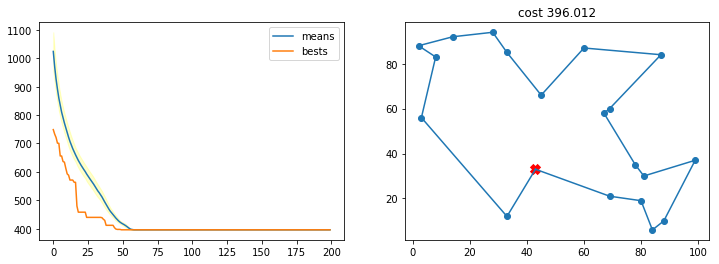

In [18]:
%run ../code/ga.py

r =  run_ga(pop_size=1000, 
               init_population_function = lambda x: TSP_initialize_population(x, n_cities), 
               mutation_function        = TSP_mutate, 
               crossover_function       = TSP_cross_over,
               cost_function            = lambda x: TSP_cost(cities, x), 
               crossover_prob           = 0.001,
               mutation_prob            = 0.001, 
               n_iters                  = 200)

best, best_costs, means, stds = r
TSP_plot_GA_result(best, best_costs, means, stds)

Con una probabilidad de mutación muy pequeña

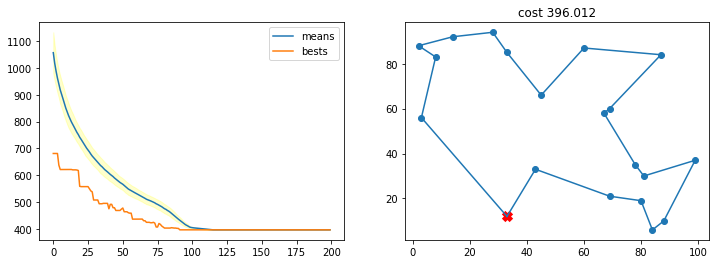

In [19]:
r =  run_ga(pop_size=1000, 
               init_population_function = lambda x: TSP_initialize_population(x, n_cities),  
               mutation_function        = TSP_mutate, 
               crossover_function       = TSP_cross_over,
               cost_function            = lambda x: TSP_cost(cities, x), 
               crossover_prob           = 0.5,
               mutation_prob            = 0.01, 
               n_iters                  = 200)

best, best_costs, means, stds = r
TSP_plot_GA_result(best, best_costs, means, stds)

Con una probabilidad de cruce muy pequeña

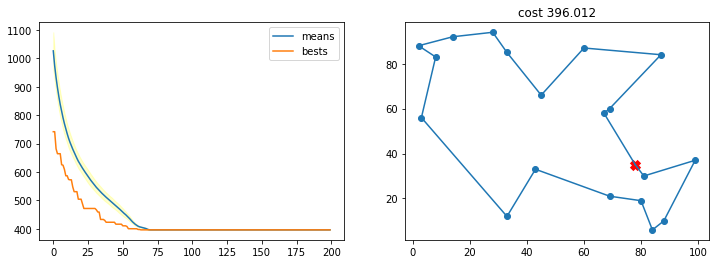

In [20]:
r =  run_ga(pop_size=1000, 
               init_population_function = lambda x: TSP_initialize_population(x, n_cities),  
               mutation_function        = TSP_mutate, 
               crossover_function       = TSP_cross_over,
               cost_function            = lambda x: TSP_cost(cities, x), 
               crossover_prob           = 0.01,
               mutation_prob            = 0.001, 
               n_iters                  = 200)

best, best_costs, means, stds = r
TSP_plot_GA_result(best, best_costs, means, stds)

Con una probabilidad de mutación muy alta

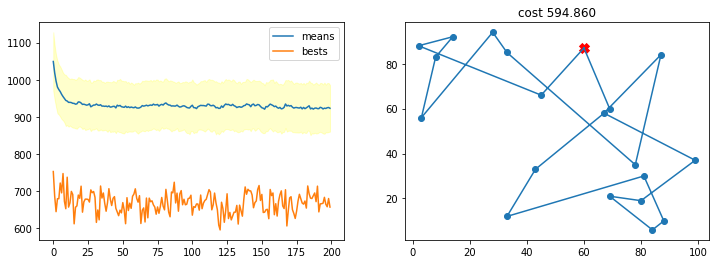

In [21]:
r =  run_ga(pop_size=1000, 
               init_population_function = lambda x: TSP_initialize_population(x, n_cities), 
               mutation_function        = TSP_mutate, 
               crossover_function       = TSP_cross_over,
               cost_function            = lambda x: TSP_cost(cities, x), 
               crossover_prob           = 0.5,
               mutation_prob            = 0.9, 
               n_iters                  = 200)

best, best_costs, means, stds = r
TSP_plot_GA_result(best, best_costs, means, stds)